<h1><font size="6">Bee or Wasp?</font></h1>

![bee_img](https://storage.googleapis.com/kagglesdsdata/datasets%2F842582%2F1437912%2Fkaggle_bee_vs_wasp%2Fbee1%2F10457143913_149e654aaa_n.jpg?GoogleAccessId=databundle-worker-v2@kaggle-161607.iam.gserviceaccount.com&Expires=1599423647&Signature=Xi2gXuRGTFXpu1zjDZWjkjXE8%2FENXgSwWR3g0Lixt%2BF9tU%2FITLalVxY8SFHcogZ95BHm7yJQatXMFAI26Db2UjkJGeQFao3qBJwGO4r0YjM%2BhTrt7b0zHHJkO070%2BoFOe5zYA5ZZJNk5dDEONu%2FrN0H4IZ14XJixr6%2Fad8YaZYR%2BZvPZ9hC83WK8bHSJHOJCIcCdnrKqgKO2aa%2BCLugF29TG%2F21xkk4Q6ORCyM4SHRZR6vH8rH2OCF2GmLofxbZcIoI9IXQR2Jp4sdaet15E6aO4g5GpfdOxHaJv5koOmJ5jqUTNYBA1C7OYM2Oxi2zV1O7jLAAv9lJWdKuoEAQC4A%3D%3D)

![](http://)






This notebook uses dataset published by [George Ray] to show a simple baseline.

Thanks for publishing a great dataset.

[George Ray]:https://www.kaggle.com/jerzydziewierz

## Import libraries

In [4]:
import os
import gc
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tqdm import tqdm

print('TensorFlow version: %s' % tf.__version__)

TensorFlow version: 2.3.0


## set configurations and read metadata

In [5]:
ROOT = 'D:\\GIT\\CV-PROJECT\\dataset\\'
SEED = 42
EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 256


df = pd.read_csv(ROOT+'labels.csv')
df.head()

id                               path  is_bee  is_wasp  is_otherinsect  \
0   1  bee1\10007154554_026417cfd0_n.jpg       1        0               0   
1   2  bee1\10024864894_6dc54d4b34_n.jpg       1        0               0   
2   3  bee1\10092043833_7306dfd1f0_n.jpg       1        0               0   
3   4   bee1\1011948979_fc3637e779_w.jpg       1        0               0   
4   5  bee1\10128235063_dca17db76c_n.jpg       1        0               0   

   is_other  photo_quality  is_validation  is_final_validation label  
0         0              1              0                    0   bee  
1         0              1              0                    1   bee  
2         0              1              1                    0   bee  
3         0              1              0                    1   bee  
4         0              1              0                    0   bee

In [6]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

## Preprocess and plot

Check the dataset and preprocess it.

In [7]:
for idx in tqdm(df.index):    
    df.loc[idx,'path']=df.loc[idx,'path'].replace('\\', '/') 
    
df.head()

100%|██████████| 17953/17953 [00:08<00:00, 2079.56it/s]


id                               path  is_bee  is_wasp  is_otherinsect  \
0   1  bee1/10007154554_026417cfd0_n.jpg       1        0               0   
1   2  bee1/10024864894_6dc54d4b34_n.jpg       1        0               0   
2   3  bee1/10092043833_7306dfd1f0_n.jpg       1        0               0   
3   4   bee1/1011948979_fc3637e779_w.jpg       1        0               0   
4   5  bee1/10128235063_dca17db76c_n.jpg       1        0               0   

   is_other  photo_quality  is_validation  is_final_validation label  
0         0              1              0                    0   bee  
1         0              1              0                    1   bee  
2         0              1              1                    0   bee  
3         0              1              0                    1   bee  
4         0              1              0                    0   bee

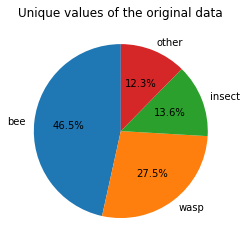

In [8]:
labels = list(df['label'].unique())
y = list(df['label'].value_counts())
plt.pie(y, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Unique values of the original data')
plt.show()

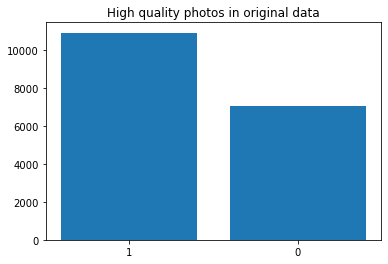

In [9]:
labels = list(df['photo_quality'].unique())
x = range(0, 2)
y = list(df['photo_quality'].value_counts())
plt.bar(x, y, tick_label=labels)
plt.title('High quality photos in original data')

plt.show()

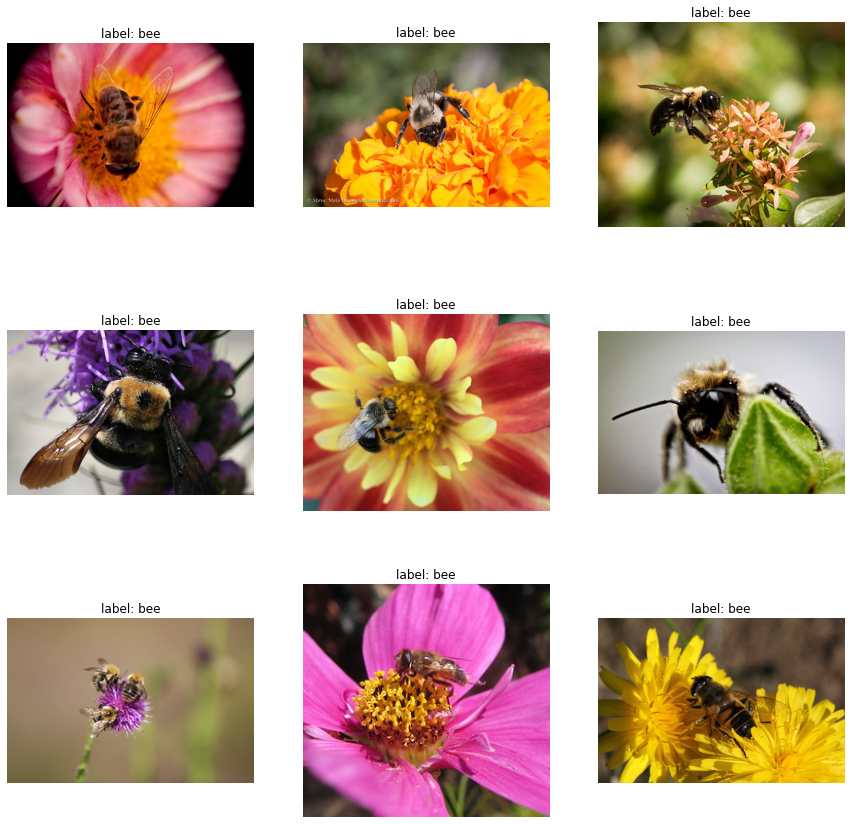

In [10]:
def img_plot(df, label):
    df = df.query('label == @label')
    imgs = []
    for path in df['path'][:9]:
        img = cv2.imread(ROOT+path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
    f, ax = plt.subplots(3, 3, figsize=(15,15))
    for i, img in enumerate(imgs):
        ax[i//3, i%3].imshow(img)
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('label: %s' % label)
    plt.show()
    
    
img_plot(df, label='bee')

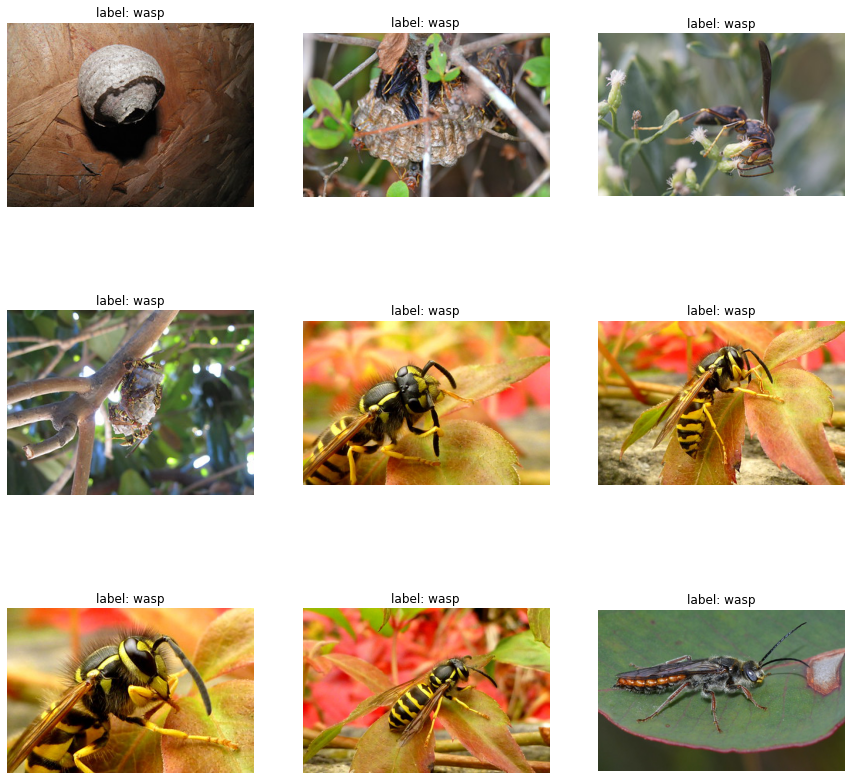

In [11]:
img_plot(df, label='wasp')

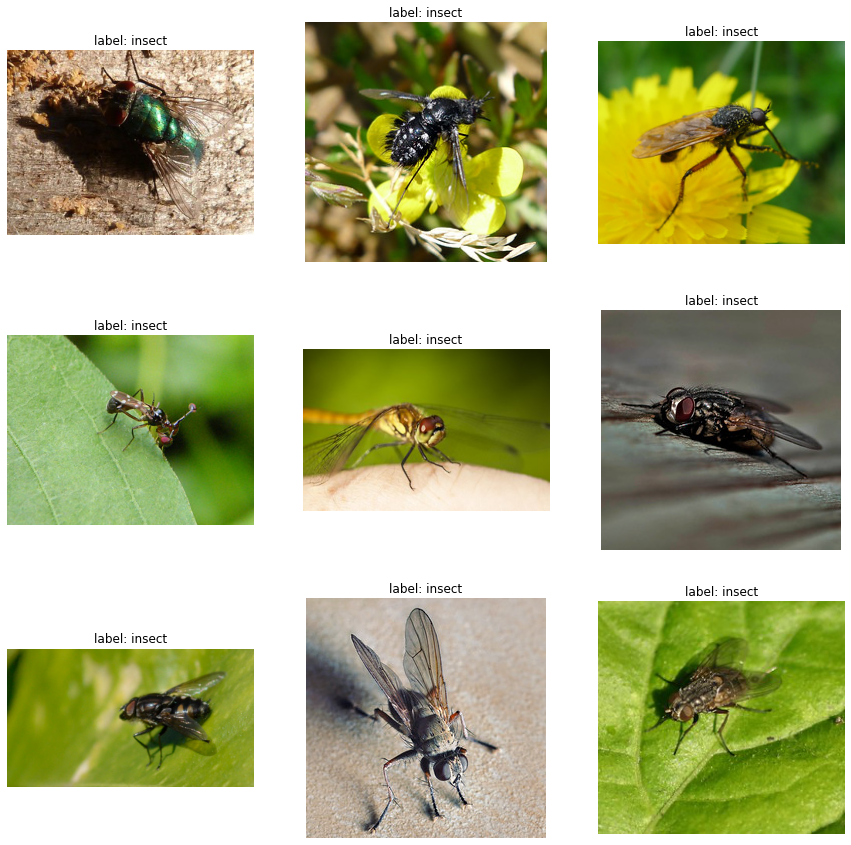

In [12]:
img_plot(df, label='insect')

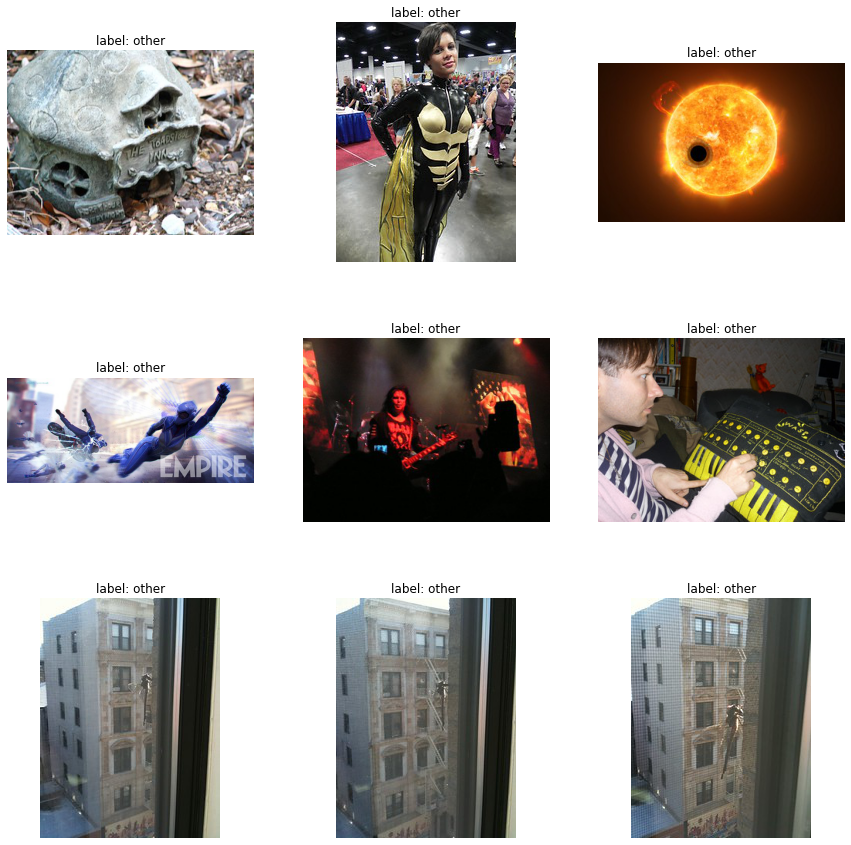

In [13]:
img_plot(df, label='other')

In [14]:
# select only high quality photos
df = df.query('photo_quality == 1')
df['label'].value_counts()

bee       2469
insect    2439
wasp      2127
Name: label, dtype: int64

In [15]:
train_df = df.query('is_validation == 0 & is_final_validation == 0').reset_index(drop=True)
val_df = df.query('is_validation == 1').reset_index(drop=True)
test_df = df.query('is_final_validation == 1').reset_index(drop=True)

## Create datasets

In [16]:
def create_datasets(df, img_size):
    imgs = []
    for path in tqdm(df['path']):
        img = cv2.imread(ROOT+path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size,img_size))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    imgs = imgs / 255.0
    df = pd.get_dummies(df['label'])
    return imgs, df


train_imgs, train_df = create_datasets(train_df, IMG_SIZE)
val_imgs, val_df = create_datasets(val_df, IMG_SIZE)
test_imgs, test_df = create_datasets(test_df, IMG_SIZE)

100%|██████████| 1071/1071 [00:07<00:00, 141.56it/s]


## Build the model

In [17]:
def build_model(img_size, n):
    inp = Input(shape=(img_size,img_size,n))
    resnet = tf.keras.applications.ResNet50(input_shape=(img_size,img_size,n), 
                                            weights='imagenet', 
                                            include_top=False)
    x = resnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(3, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x) 
    opt = tf.keras.optimizers.SGD(momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model(IMG_SIZE, 3)
model.summary()

94773248/94765736 [==============================] - 7s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________


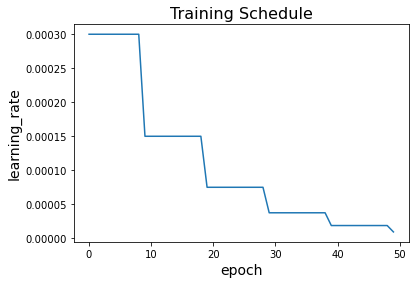

In [18]:
def get_lr_callback(batch_size=32, plot=False):
    start_lr = 3e-4
    def step_decay(epoch):
        drop = 0.5
        epochs_drop = 10.0
        lr = start_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        return lr
    
    lr_callback = tf.keras.callbacks.LearningRateScheduler(step_decay)
    if plot == True:
        rng = [i for i in range(EPOCHS)]
        y = [step_decay(x) for x in rng]
        plt.plot(rng, y)
        plt.xlabel('epoch', size=14)
        plt.ylabel('learning_rate', size=14)
        plt.title('Training Schedule', size=16)
        plt.show()
        
    return lr_callback


get_lr_callback(plot=True)

In [19]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, 
                                               verbose=1, 
                                               restore_best_weights=True)

history = model.fit(train_imgs, 
                    train_df, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=[es_callback, get_lr_callback(BATCH_SIZE)], 
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

gc.collect()

Epoch 1/50
 19/154 [==>...........................] - ETA: 32:45 - loss: 1.2286 - accuracy: 0.4211

KeyboardInterrupt: 

In [17]:
model.evaluate(test_imgs, test_df) 

34/34 [==============================] - 3s 78ms/step - loss: 0.2595 - accuracy: 0.9234


[0.2594708204269409, 0.9234317541122437]